In [1]:
import sys, os
sys.path.append(os.path.abspath("../src"))

from nets import MLP
from burger_ground_truth import burgers_ground_truth_fd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


# Transport equation

Use 
\begin{align}
\dfrac{\partial u}{\partial t} + c\,\dfrac{\partial u}{\partial x} &= 0,
\end{align}
where $u(t,x)$ represent a quantity transported. 

# Case 1

Consider a waveform of the form $A(t)$ at the edge $x=0$, traveling along the segment with velocity $c$, then the solution to (1) is: 
$$u(x,y) = A\left(t-\dfrac{x}{c}\right)$$

**Objective** Given the information at two positions $x_1$ and $x_2$ of the waveform, then obtain the velocity $c$ at which it travels.

In [15]:
x_seg = 0.06  # mts
t_max = 2     # seg

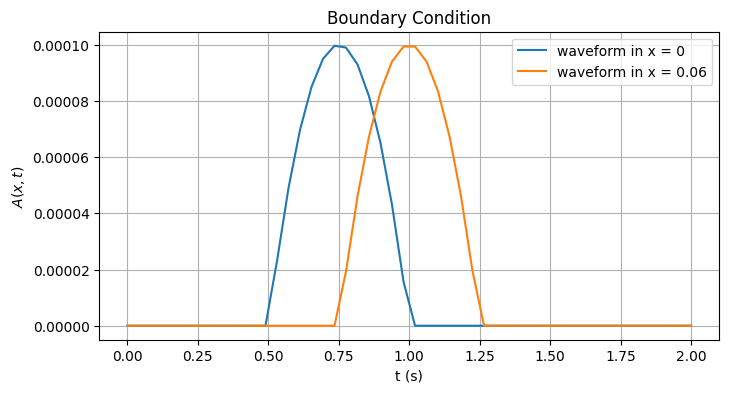

In [24]:
def wave_form(t, t_m, h=1e-4):
    """
    Pulso parabólico en el tiempo:
      - 0 fuera de [t_m/4, t_m/2]
      - parábola cóncava hacia abajo dentro
      - máximo h
    """

    t = np.asarray(t, dtype = float)
    a = t_m/4
    b = t_m/2
    # m = 0.5 * (a+b)

    k = 4.0 * h / (b-a)**2

    y = np.zeros_like(t)
    mask = (t>=a) & (t<=b)
    y[mask] = k * (t[mask]-a) * (b-t[mask])

    return y.item() if y.ndim == 0 else y


ts = np.linspace(0, t_max, 50)
A_0 = wave_form(ts, 2)

c = 0.06/0.25
dt_shift = 0.25
A_shift = wave_form(ts - dt_shift, t_m=2.0)   # shift a la derecha (retardo)



#grafica 
plt.figure(figsize=(8, 4))
plt.plot(ts, A_0, label='waveform in x = 0')
plt.plot(ts, A_shift, label='waveform in x = 0.06')  # muestra el retardo
plt.title('Boundary Condition')
plt.xlabel('t (s)')
plt.ylabel('$A(x,t)$')
plt.grid()
plt.legend()
plt.show()

In [ ]:
c = 0.06/0.25
dt_shift = 0.25
A_shift = wave_form(ts - dt_shift, t_m=2.0)   # shift a la derecha (retardo)


In [ ]:
def A_profile_x(x, t, c=2.0, t_m=1.0, h=1e-4):
    """
    Perfil viajero: A(x,t) = wave_form(t - x/c)
    Devuelve:
      - escalar si x y t son escalares
      - vector si uno es vector y el otro escalar
      - matriz (Nt, Nx) si ambos son vectores
    """
    x = np.asarray(x, dtype=float)
    t = np.asarray(t, dtype=float)


    # Queremos que t - x/c haga broadcasting como (Nt, Nx)
    # t[:,None] - x[None,:]
    if x.ndim == 0 and t.ndim == 0:
        tau = t - x / c
        return wave_form(tau, t_m=t_m, h=h)

    if x.ndim == 0 and t.ndim == 1:
        tau = t - x / c
        return wave_form(tau, t_m=t_m, h=h)

    if x.ndim == 1 and t.ndim == 0:
        tau = t - x / c
        return wave_form(tau, t_m=t_m, h=h)

    if x.ndim == 1 and t.ndim == 1:
        tau = t[:, None] - x[None, :] / c   # (Nt, Nx)
        return wave_form(tau, t_m=t_m, h=h)

    raise ValueError("x y t deben ser escalares o vectores 1D.")


t_max = 1.0
ts = np.linspace(0, t_max, 1000)
A_0 = wave_form(ts, t_m=t_max, h=1e-4)

L = 0.06
x_seg = np.linspace(0, L, 600)
c = 0.06/0.25

t0 = 0.4  # el tiempo que quieras
A_x = A_profile_x(x_seg, t0, c=c, t_m=t_max, h=1e-4)

plt.figure()
plt.plot(x_seg, A_x)
plt.xlabel("x")
plt.ylabel("A(x,t0) = A(t0 - x/c)")
plt.grid(True)
plt.show()



In [ ]:
Considere un perfil parabolico escalon que en el borde $x=0$

# PINNverse

In [2]:
net = MLP(2, 1, 3, 20, activation_fn = nn.Tanh())

In [3]:
net(torch.tensor(np.random.rand(10, 2), dtype=torch.float32))

tensor([[-0.1564],
        [-0.1476],
        [-0.1565],
        [-0.1444],
        [-0.1537],
        [-0.1503],
        [-0.1443],
        [-0.1530],
        [-0.1470],
        [-0.1436]], grad_fn=<AddmmBackward0>)

In [19]:
def burgers_residual(model, x, t, nu):
    u = model(torch.cat([x, t], dim=1))  
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    r = u_t + u*u_x - nu*u_xx
    return r, u

In [20]:
x_t = torch.tensor(np.random.rand(10, 1), dtype=torch.float32).requires_grad_(True)
t_t = torch.tensor(np.random.rand(10, 1), dtype=torch.float32).requires_grad_(True)

burgers_residual(net, x_t, t_t, nu=0.01)

(tensor([[-0.0054],
         [-0.0071],
         [-0.0060],
         [-0.0064],
         [-0.0077],
         [-0.0063],
         [-0.0073],
         [-0.0062],
         [-0.0054],
         [-0.0054]], grad_fn=<SubBackward0>),
 tensor([[-0.0600],
         [-0.0422],
         [-0.0628],
         [-0.0687],
         [-0.0406],
         [-0.0799],
         [-0.0416],
         [-0.0595],
         [-0.0734],
         [-0.0457]], grad_fn=<AddmmBackward0>))